# Soil Water Retention Curve

A soil water retneiton curve represents the relationship between the amount of water in the soil expressed as the volumetric water content and the energy state of the soil water expressed in $J/kg$, $J/m^3$, or $kPa$

Soil water retention curves are determined empirically by collecting soil samples and using a series of instruments to quantify the soil water content at different energy levels.

The mos popular model is that proposed by van Genuchten in 1980:

$$ \frac{\theta - \theta_r}{\theta_s - \theta_r} = [1 + (-\alpha \psi_m)^n]^{-m} $$
 

In [125]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


In [126]:
df = pd.read_csv('../datasets/soil_water_retention_curve.csv')
df.head()

,matric,theta
0,0.001,44.8
1,0.001,44.8
2,0.056,44.8
3,0.173,44.7
4,0.286,44.7


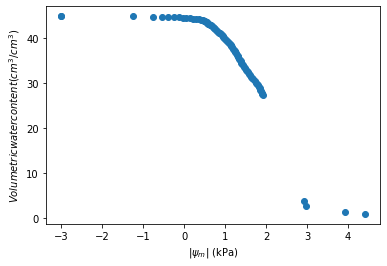

In [127]:
# Plot observations
plt.scatter(np.log10(df["matric"]),df["theta"])
plt.xlabel('$|\psi_m|$ (kPa)')
plt.ylabel("$Volumetric water content (cm^3/cm^3)$")
plt.show()


## Define soil water retention model

In [128]:
model = lambda x, alpha, n, m, theta_r, theta_s: theta_r + (theta_s-theta_r)*(1+(alpha*x)**n)**-m


In [129]:
# Test function for a single value of matric potential
test_matric = 150
model(test_matric, 0.002, 1.5, 1, 0.05, 0.5)


0.4364927592361794

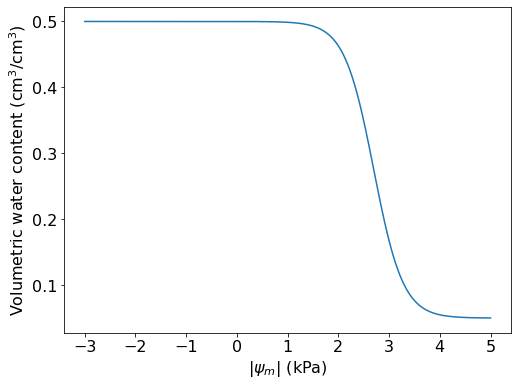

In [130]:
# Test function for a range of matric potentials

matric = np.logspace(-3,5,1000)
plt.figure(figsize=(8,6))
plt.plot(np.log10(matric), model(matric,0.002,1.5,1,0.05,0.5))
plt.xlabel('$|\psi_m|$ (kPa)', size=16)
plt.ylabel('Volumetric water content (cm$^3$/cm$^3$)', size=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()


## Fit model

In [131]:
xdata = df["matric"]
ydata = df["theta"]/100
#p0 = [0.002, 1.5, 1, 0.05, 0.5]
lb = [0, 1, 0, 0, 0.35]
ub = [1, 5, 2, 0.25, 0.55]
bounds=(lb,ub)
par_opt, par_cov = curve_fit(model, xdata, ydata, bounds=bounds)
print(par_opt)


[1.25680016e-02 1.00000000e+00 7.86928044e-01 5.86306870e-14
 4.43268752e-01]


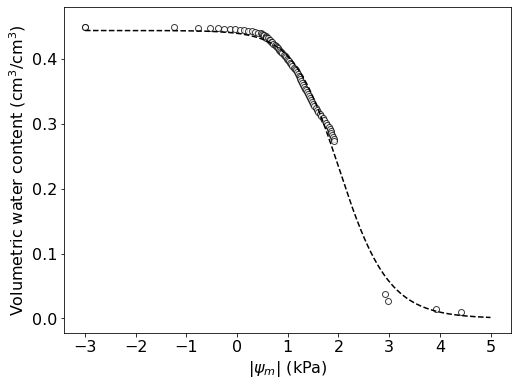

In [132]:
# Plot results
plt.figure(figsize=(8,6))
plt.scatter(np.log10(xdata), ydata, marker='o', facecolor='w', alpha=0.75, edgecolor='k')
plt.plot(np.log10(matric), model(matric, *par_opt), '--k')
plt.xlabel('$|\psi_m|$ (kPa)', size=16)
plt.ylabel('Volumetric water content (cm$^3$/cm$^3$)', size=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()


## References

van Genuchten, M.T., 1980. A closed form equation for predicting hydraulic conductivity of unsaturated soils: Journal of the Soil Science Society of America.
    
Groenevelt, P.H. and Grant, C.D., 2004. A new model for the soil‐water retention curve that solves the problem of residual water contents. European Journal of Soil Science, 55(3), pp.479-485.